# Imports and Setup


In [3]:
!git clone https://github.com/Hari31416/TorchLight
!cp -r ./TorchLight/* ./

Cloning into 'TorchLight'...
remote: Enumerating objects: 271, done.
remote: Counting objects: 100% (271/271), done.
remote: Compressing objects: 100% (180/180), done.
remote: Total 271 (delta 167), reused 192 (delta 88), pack-reused 0 (from 0)
Receiving objects: 100% (271/271), 19.62 MiB | 38.86 MiB/s, done.
Resolving deltas: 100% (167/167), done.


In [6]:
from torchlight.utils import (
    create_simple_logger,
    T,
    A,
)
from torchlight.objective import (
    create_objective_with_multi_hook,
)
from torchlight.image import convert_to_valid_rgb
from torchlight.optimize import FeatureViz
from torchlight.models import InceptionV1
from torchlight.io import show_images, save_images

import torch
import torchvision.transforms as transforms

import numpy as np
from PIL import Image
from typing import List, Optional
from copy import deepcopy

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger = create_simple_logger(
    "deepdream", set_level_to_all_loggers=True, level="warning"
)  # avoid spamming the console with debug and log messages

# DeepDream


In [8]:
model = InceptionV1().eval().to(device)

Downloading: "https://github.com/ProGamerGov/pytorch-old-tensorflow-models/raw/master/inception5h.pth" to /root/.cache/torch/hub/checkpoints/inception5h.pth
100%|██████████| 27.0M/27.0M [00:00<00:00, 221MB/s]


In [9]:
def load_image(path, h: Optional[int] = None, w: Optional[int] = None) -> A:
    """Loads an image from a given path and resizes it to the given dimensions. Returns the image as a numpy array."""
    image = Image.open(path)
    if h is not None and w is not None:
        image = image.resize((w, h))
    image = np.array(image)
    image = image / 255.0
    return image

In [10]:
def mean_loss(layers: List[T]) -> T:
    return -sum([layer.mean() for layer in layers]) / len(layers)


def resize_tf_image(image, size):
    return transforms.Resize(size)(image)


def tensors_are_equal(t1, t2):
    return torch.allclose(t1, t2)

In [70]:
layers = [
    # "mixed3a",
    # "mixed3b",
    "mixed4a",
    # "mixed4b",
    # "mixed4c",
    "mixed4d",
    "mixed4e",
    "mixed5a",
    "mixed5b",
]

og_h = 512
og_w = 720
image_name = "under_the_sea"
image = load_image(f"images/{image_name}.jpg", h=og_h, w=og_w)
param = (
    torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
)  # define at the global namespace


def create_deepdream_image():
    img = param
    img.requires_grad_(True)

    return [img], lambda: convert_to_valid_rgb(img, decorrelate=False, sigmoid=False)


octave_scale = 1.3
octaves = [-2, -1, 0, 1, 2]
octave_images = []
all_images = []
for octave in octaves:
    old_param = deepcopy(param.detach().clone())
    new_size_h = int(og_h * octave_scale**octave)
    new_size_w = int(og_w * octave_scale**octave)
    print(f"New Size: {(new_size_h, new_size_w)}")
    extra_t = [
        lambda x: resize_tf_image(x, (new_size_h, new_size_w)),
    ]
    objective = create_objective_with_multi_hook(
        extractor_function=mean_loss,
        layer_names=layers,
    )
    fv = FeatureViz(model=model, objective=objective)
    images = fv.visualize(
        create_deepdream_image,
        show_last_image=False,
        show_progress=True,
        thresholds=range(0, 201, 20),
        lr=0.007,
        extra_transformations=extra_t,
    )
    octave_images.append(images[-1])
    all_images.extend(images)
    assert not tensors_are_equal(old_param, param), "Parameters are the same"

New Size: (302, 426)


  0%|          | 0/201 [00:00<?, ?it/s]

New Size: (393, 553)


  0%|          | 0/201 [00:00<?, ?it/s]

New Size: (512, 720)


  0%|          | 0/201 [00:00<?, ?it/s]

New Size: (665, 936)


  0%|          | 0/201 [00:00<?, ?it/s]

New Size: (865, 1216)


  0%|          | 0/201 [00:00<?, ?it/s]


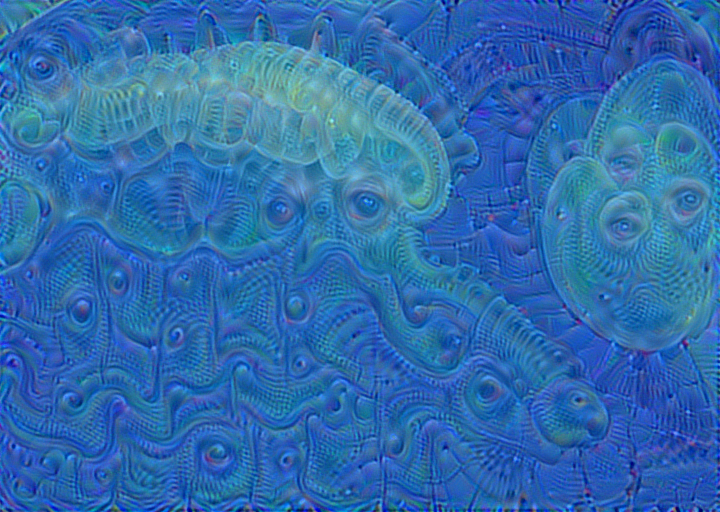
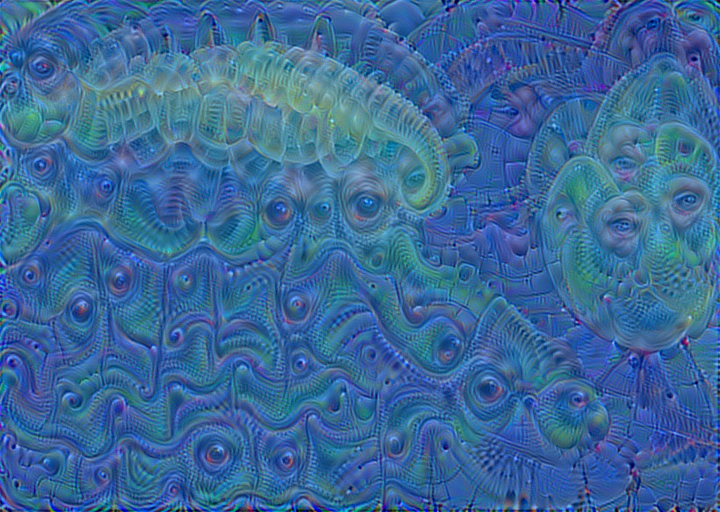
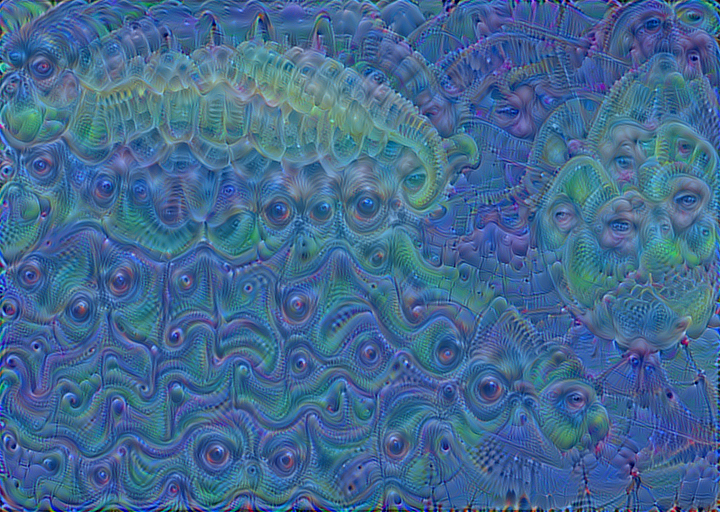
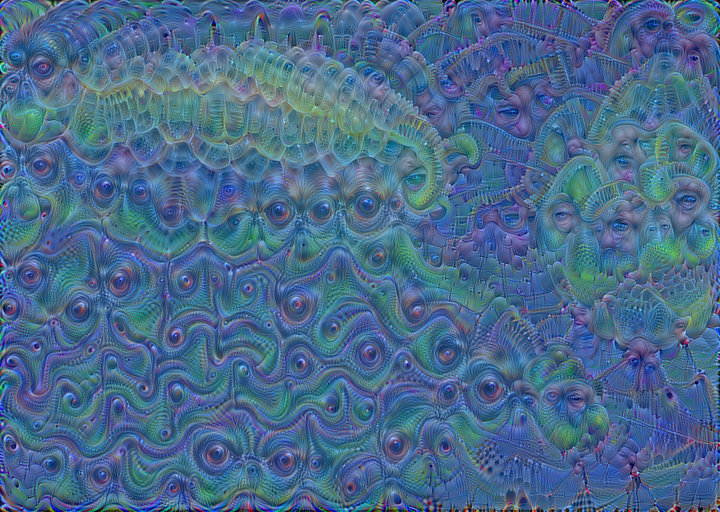
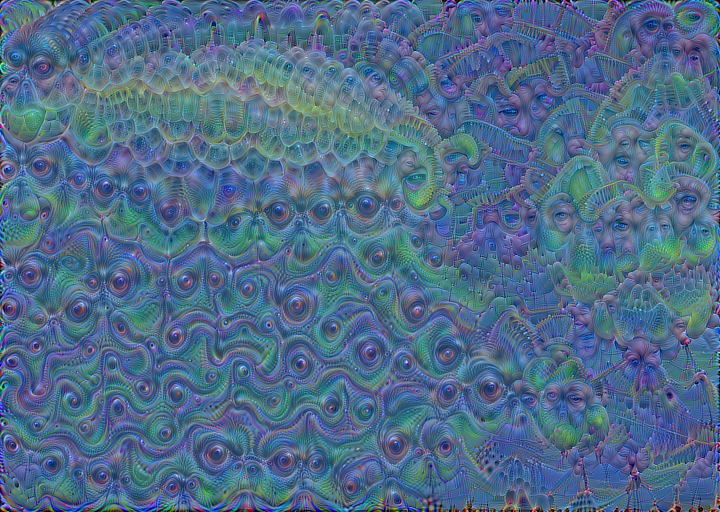

In [72]:
show_images(octave_images, labels=octaves, n_rows=len(octaves), domain=(0.1, 1))

In [73]:
save_images(all_images, save_path=f"{image_name}_deepdream.mp4",  fps=5, domain=(0.1, 1))
save_images(all_images, save_path=f"{image_name}_deepdream.gif", domain=(0.1, 1))